# Notebook 2
# MACHINE LEARNING

Após análise exploratória (EDA), farei os pré-processamento da mesma forma que o primeiro e testarei alguns modelos de Machine Learning.

# Importando o Dataset

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import skew, norm, probplot, boxcox

from sklearn.model_selection import RandomizedSearchCV

import re
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel('houses_to_rent_v2_Copia.xlsx')
df.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065.0,3300,211,42.0,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200.0,4960,1750,63.0,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000.0,2800,0,41.0,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270.0,1112,22,17.0,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0.0,800,25,11.0,836


In [3]:
# removendo caracteres especiais e colocando '_' entre os espaços para facilitar a remoção do '(R$)'
df.columns = df.columns.map(lambda x: re.sub(r'\W+', '_', x))

# substituindo nosso padrão por ''
df.columns = df.columns.str.replace('_R_','')

df.columns

Index(['city', 'area', 'rooms', 'bathroom', 'parking_spaces', 'floor',
       'animal', 'furniture', 'hoa', 'rent_amount', 'property_tax',
       'fire_insurance', 'total'],
      dtype='object')

In [4]:
# separando em dois conjuntos de dados
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8553 entries, 6239 to 7270
Data columns (total 13 columns):
city              8553 non-null object
area              8553 non-null int64
rooms             8553 non-null int64
bathroom          8553 non-null int64
parking_spaces    8553 non-null int64
floor             8553 non-null object
animal            8499 non-null object
furniture         8553 non-null object
hoa               8505 non-null float64
rent_amount       8553 non-null int64
property_tax      8553 non-null int64
fire_insurance    8499 non-null float64
total             8553 non-null int64
dtypes: float64(2), int64(7), object(4)
memory usage: 935.5+ KB


In [6]:
df_train.isnull().sum()

city               0
area               0
rooms              0
bathroom           0
parking_spaces     0
floor              0
animal            54
furniture          0
hoa               48
rent_amount        0
property_tax       0
fire_insurance    54
total              0
dtype: int64

Identificado alguns valores missing

# Tratando dados missing

In [7]:
# começando pela coluna animal
df.animal.value_counts(dropna=False)

acept        8262
not acept    2360
NaN            70
Name: animal, dtype: int64

In [8]:
# vou pegar a cidade como minha referência e vou agrupar
# para saber, qual a proporção de dados missing por cidade
df_train.groupby(['city'])['animal'].value_counts(dropna=False)

city            animal   
Belo Horizonte  acept         767
                not acept     270
                NaN             3
Campinas        acept         546
                not acept     124
                NaN             2
Porto Alegre    acept         798
                not acept     141
                NaN             5
Rio de Janeiro  acept         952
                not acept     237
                NaN            12
São Paulo       acept        3540
                not acept    1124
                NaN            32
Name: animal, dtype: int64

No caso da coluna "animal" não terem muitos dados faltantes, optei em substituir pelo valor mais frequente por cidade

In [9]:
# como cidade é minha referência
# vou criar uma lista para passar em um loop
cidades = df_train.city.unique()

# usando "Imputation" do sklearn para substituir pelo valor mais frequente
imp_animal = SimpleImputer(strategy='most_frequent')

for i in cidades:

    imp_animal.fit(np.array(df_train[df_train.city==i]['animal']).reshape(-1,1))

    df_train.loc[df_train.city==i, 'animal'] = imp_animal.transform(np.array(df_train[df_train.city==i]['animal']).reshape(-1,1))

In [10]:
# conferindo o resultado
df_train.groupby(['city'])['animal'].value_counts(dropna=False)

city            animal   
Belo Horizonte  acept         770
                not acept     270
Campinas        acept         548
                not acept     124
Porto Alegre    acept         803
                not acept     141
Rio de Janeiro  acept         964
                not acept     237
São Paulo       acept        3572
                not acept    1124
Name: animal, dtype: int64

In [11]:
# checando os dados da coluna "hoa" e "fire_insurance" que são do tipo "float"
df_train.describe()[['hoa','fire_insurance']].T

,count,mean,std,min,25%,50%,75%,max
hoa,8505.0,1244.73980,17473.047438,0.0,160.0,560.0,1250.0,1117000.0
fire_insurance,8499.0,53.58101,48.122362,3.0,21.0,36.0,68.0,677.0


Analisando os valores, observamos outliers nos dois conjuntos. Inicialmente adorarei a seguinte estratégia:
- para a **hoa** vou imputar os valores da **mediana**.
- para o **fire_insurance** vou imputar os valores da **média**.

Acredito que os valores de condomínio e seguro são de acordo com as cidade, depois vou tentar validar esta hipótese.

In [12]:
imp_hoa = SimpleImputer(strategy='median')

for i in cidades:

    imp_hoa.fit(np.array(df_train[df_train.city==i]['hoa']).reshape(-1,1))

    df_train.loc[df_train.city==i, 'hoa'] = imp_hoa.transform(np.array(df_train[df_train.city==i]['hoa']).reshape(-1,1))

In [13]:
imp_fireInsur = SimpleImputer(strategy='mean')

for i in cidades:

    imp_fireInsur.fit(np.array(df_train[df_train.city==i]['fire_insurance']).reshape(-1,1))

    df_train.loc[df_train.city==i, 'fire_insurance'] = imp_fireInsur.transform(np.array(df_train[df_train.city==i]['fire_insurance']).reshape(-1,1))

In [14]:
# checando se todos os dados foram preenchidos:
df_train.isnull().sum()

city              0
area              0
rooms             0
bathroom          0
parking_spaces    0
floor             0
animal            0
furniture         0
hoa               0
rent_amount       0
property_tax      0
fire_insurance    0
total             0
dtype: int64

In [15]:
# olhando o tipo das features
df_train.select_dtypes(include='object')

,city,floor,animal,furniture
6239,São Paulo,19,acept,furnished
9805,São Paulo,-,acept,not furnished
10314,Campinas,6,acept,not furnished
10072,Porto Alegre,1,acept,furnished
3026,São Paulo,12,acept,not furnished
...,...,...,...,...
5734,São Paulo,1,not acept,furnished
5191,São Paulo,1,not acept,not furnished
5390,Rio de Janeiro,11,acept,furnished
860,São Paulo,5,not acept,furnished


In [16]:
# a feature "floor" já está no formato, porém está como 'str' por causa de um '-'
# vou alterar o '-' para 0

df_train.floor = df_train.floor.replace('-',0)

Agora sim, podemos responder às perguntas iniciais

In [17]:
# selecionando as variáveis categóricas
df_train.select_dtypes(['object']).columns

Index(['city', 'animal', 'furniture'], dtype='object')

In [18]:
# para a primeira feature vou utilizar o label encoder
# instanciando a LabelEncoder
le = LabelEncoder()

le.fit(df_train.city)

df_train['city'] = le.transform(df_train.city)

In [19]:
# nesse caso vou fazer algo mais simples
df_train['animal'] = df_train.animal.map({'acept':1, 'not acept':0})
df_train['furniture'] = df_train.furniture.map({'furnished':1, 'not furnished':0})

In [20]:
df_train.head()

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax,fire_insurance,total
6239,4,200,3,4,3,19,1,1,2247.0,8500,1000,33.0,11780
9805,4,225,3,2,2,0,1,0,0.0,2300,209,35.0,2544
10314,1,53,1,1,0,6,1,0,403.0,500,15,7.0,925
10072,2,42,1,1,1,1,1,1,650.0,2400,81,36.0,3167
3026,4,101,2,2,1,12,1,0,582.0,1700,0,22.0,2304


((array([-3.77179675, -3.54446387, -3.41955413, ...,  3.41955413,
          3.54446387,  3.77179675]),
  array([  450,   460,   500, ..., 25000, 30000, 45000], dtype=int64)),
 (3058.609833864335, 3916.4778440313335, 0.8916273640830679))

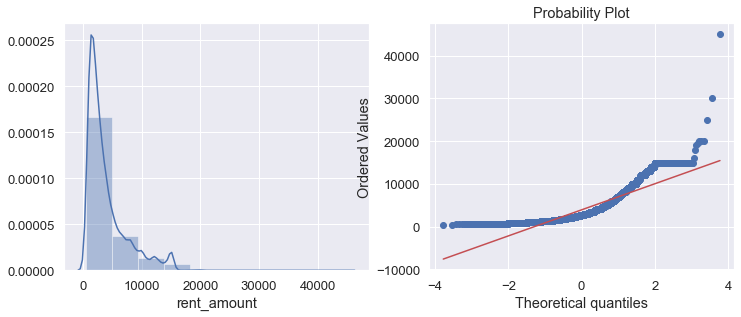

In [21]:
fig = plt.figure(figsize=(12,10))
sns.set(font_scale=1.2)

fig1 = fig.add_subplot(221)
sns.distplot(df_train['rent_amount'], bins=10)

fig2 = fig.add_subplot(222)
probplot(df_train['rent_amount'], plot=fig2)

Aplicando a normalização com a função np.log1p

((array([-3.77179675, -3.54446387, -3.41955413, ...,  3.41955413,
          3.54446387,  3.77179675]),
  array([ 6.11146734,  6.13339804,  6.2166061 , ..., 10.1266711 ,
         10.30898599, 10.71443999])),
 (0.7853863236404341, 7.952972268253242, 0.9913421720895685))

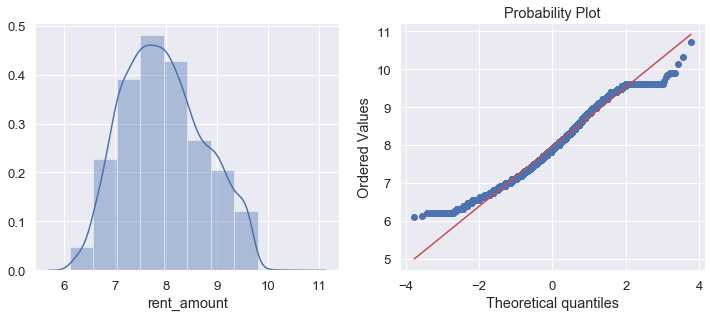

In [22]:
df_train['rent_amount'] = np.log1p(df_train.rent_amount)

fig = plt.figure(figsize=(12,10))
sns.set(font_scale=1.2)

fig1 = fig.add_subplot(221)
sns.distplot(df_train['rent_amount'], bins=10)

fig2 = fig.add_subplot(222)
probplot(df_train['rent_amount'], plot=fig2)

# Machine Learning

## Prevendo o valor do alguel

In [23]:
# X = df_train[['property_tax', 'fire_insurance']]
# y = df_train['rent_amount']

In [24]:
# vou tirar a feature "total" pois acredito não ser uma variável preditiva, uma vez que o total geral
# incluindo nossa variável target

# separando X e y
X = df_train.drop(['rent_amount', 'total'], axis=1)
y = df_train['rent_amount']

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.5, random_state=42)

In [26]:
# property_tax e fire_insurance correlacionam fortemente com a variável target
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(4276, 11) (4276,) (4277, 11) (4277,)


In [27]:
seed=42

# instanciando os modelos
lr = LinearRegression(normalize=True)
dtr = DecisionTreeRegressor(random_state=seed)
rfr = RandomForestRegressor(n_estimators=1000, min_samples_leaf=2, random_state=seed)
lgbm = LGBMRegressor(n_estimators=1000, random_state=seed)

# agrupando os modelos
model_list = ((lr, 'Linear Regression'),
              (dtr, 'Decision Tree'),
              (rfr, 'Random Forest'),
              (lgbm, 'LightGBM'))

for model, name in model_list:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    print('-------------------------------------')
    print(f'{name}:')
    print(f'MAE: {mean_absolute_error(y_valid, y_pred)}')
    print(f'RMSE: {mean_squared_error(y_valid, y_pred)}')
    print(f'R^2: {r2_score(y_valid, y_pred)}')

-------------------------------------
Linear Regression:
MAE: 0.23891909238790368
RMSE: 0.22157112769789494
R^2: 0.6482873892509466
-------------------------------------
Decision Tree:
MAE: 0.03768826420836005
RMSE: 0.017170980952521318
R^2: 0.9727435130981151
-------------------------------------
Random Forest:
MAE: 0.03115782135100562
RMSE: 0.0076096526601668255
R^2: 0.9879207601107218
-------------------------------------
LightGBM:
MAE: 0.04308376075397287
RMSE: 0.008273689534165714
R^2: 0.9868666961403194


Depois da variável target normalizada, todos os modelos performaram bem, vou escolher o Forest para mais testes, pois foi o modelo com as melhores métricas.

# Tunning dos hiperparâmetros

In [38]:
from pprint import pprint

# olhando os parâmetros atuais
print('Parâmetros atuais em uso:\n')
pprint(rfr.get_params())

Parâmetros atuais em uso:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [56]:
# definindo a lista para testar os hiperparâmetros

# número de árvores na floresta
n_estimators = [100, 500, 1000]

# número máximo de features para separar o nó
max_features = ['auto', 'sqrt']

# número máximo de níveis na árvore
# max_depth = [1, 2, None]

# número mínimo no nó antes de separar
min_samples_split = [2, 5, 10]

# número mínimo de dados permitidos no nó
min_samples_leaf = [1, 2, 4]

# método para reamostragem (com ou sem substituição)
bootstrap = [True, False]


# criando a grade aleatória

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 500, 1000]}


In [57]:
print(f'Se usássemos o GridSearchCV com todas as combinações possíveis, teríamos: {2*4*2*3*3*3} iterações')

Se usássemos o GridSearchCV com todas as combinações possíveis, teríamos: 432 iterações


In [58]:
# usando o random grid para encontrar os melhores hiperparâmetros

# instanciando o modelo
rf = RandomForestRegressor()

# procurar 100 iterações com 10 fold cross validation
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=10, verbose=2, 
                               random_state=seed, n_jobs=-1)

# treinando o modelo com busca aleatória
rf_random.fit(X,y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 40.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 64.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 96.7min finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                             

In [86]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [87]:
base_accuracy = evaluate(rfr, X_train, y_train)

Model Performance
Average Error: 0.0181 degrees.
Accuracy = 99.76%.


In [88]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_train, y_train)

Model Performance
Average Error: 0.0158 degrees.
Accuracy = 99.79%.


In [89]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 0.03%.


Tivemos uma melhora de 0.03%, dependendo da quantidade de dados, esse valor pode ser relevante, no nosso caso que temos poucos dados, não é muito significativo.

Como a acurária está podemos estar correndo o risco de overfitting, como já encontramos os melhores parâmetros para prevermos o valor dos alugueis com um mínimo de erro, vou usar esses parâmetros para os dados de treino e verificar o quanto está performando.

# Rodando o modelo nos dados de teste

Os dados de teste são um conjunto de dados no qual fica separado, aguardando para quando os parâmetros forem ajustados nos dados de treino e validação, utilizamos para rodar o modelo tomando o cuidado para não vazar nenhuma estatística do "futuro" ou seja, o modelo não pode ter visto informações dos dados de teste.

## Analisando os dados de teste e ajustando com base nos dados de treino

In [29]:
df_test.isnull().sum()

city               0
area               0
rooms              0
bathroom           0
parking_spaces     0
floor              0
animal            16
furniture          0
hoa               12
rent_amount        0
property_tax       0
fire_insurance     9
total              0
dtype: int64

In [30]:
# como cidade é minha referência
# vou criar uma lista para passar em um loop
cidades = df_test.city.unique()

for i in cidades:

    df_test.loc[df_test.city==i, 'animal'] = imp_animal.transform(np.array(df_test[df_test.city==i]['animal']).reshape(-1,1))
    
    
for i in cidades:

    df_test.loc[df_test.city==i, 'hoa'] = imp_hoa.transform(np.array(df_test[df_test.city==i]['hoa']).reshape(-1,1))
    
    
for i in cidades:

    df_test.loc[df_test.city==i, 'fire_insurance'] = imp_fireInsur.transform(np.array(df_test[df_test.city==i]['fire_insurance']).reshape(-1,1))

In [31]:
# a feature "floor" já está no formato, porém está como 'str' por causa de um '-'
# vou alterar o '-' para 0

df_test.floor = df_test.floor.replace('-',0)



# para a primeira feature vou utilizar o label encoder
# ATENÇÃO: para esses dados, utilizamos o transform e não o Fit - Transform.
df_test['city'] = le.transform(df_test.city)


# nesse caso vou fazer algo mais simples
df_test['animal'] = df_test.animal.map({'acept':1, 'not acept':0})
df_test['furniture'] = df_test.furniture.map({'furnished':1, 'not furnished':0})

In [32]:
df_test['rent_amount'] = np.log1p(df_test.rent_amount)

In [33]:
X_test = df_test.drop(['rent_amount', 'total'], axis=1)
y_test = df_test['rent_amount']

In [74]:
y_test

array([[7.82444593, 7.55013534, 7.60140233, ..., 6.90875478, 7.97281078,
        6.80350526]])

In [81]:
print('Rodando o modelo com os melhores parâmetros, nos dados de treino:\n')
base_accuracy = evaluate(best_random, X_train, y_train)
print('--------------------------------------------------------------------\n')
print('Rodando o modelo com os melhores parâmetros, nos dados de teste:\n')
random_accuracy = evaluate(best_random, X_test, y_test)
print('--------------------------------------------------------------------\n')
print('Comparando os resultados:\n')
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Rodando o modelo com os melhores parâmetros, nos dados de treino:

Model Performance
Average Error: 0.0158 degrees.
Accuracy = 99.79%.
--------------------------------------------------------------------

Rodando o modelo com os melhores parâmetros, nos dados de teste:

Model Performance
Average Error: 0.0292 degrees.
Accuracy = 99.62%.
--------------------------------------------------------------------

Comparando os resultados:

Improvement of -0.17%.


Podemos analisar os primeiros 50 resultados (pode ser qualquer valor), comparando valor real dos dados de teste e o valor previsto pelo modelo.

MAE: 0.02915153822957319
RMSE: 0.010391702246885586
R^2: 0.98286489147794


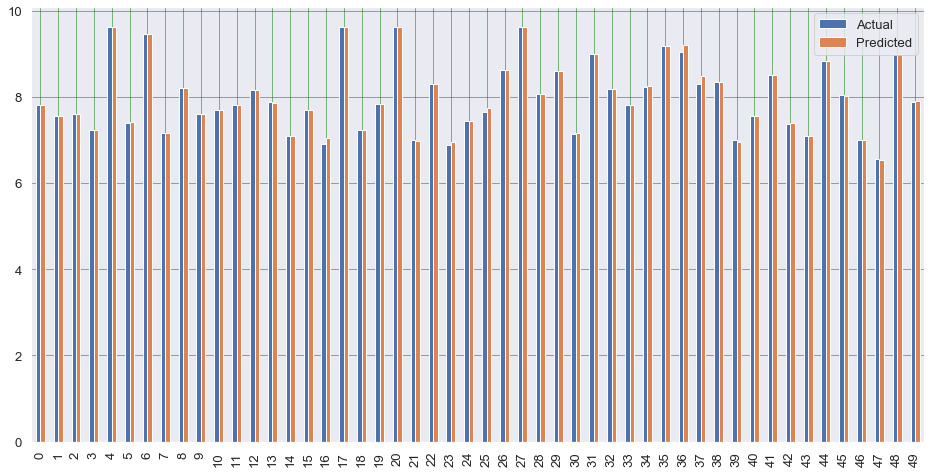

In [92]:
# utilizando os dados de teste com os melhores parâmetros para Random Forest com esses dados
# visualizando os primeiros 50 dados comparando o real com o previsto pelo modelo
y_pred = best_random.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE: {mean_squared_error(y_test, y_pred)}')
print(f'R^2: {r2_score(y_test, y_pred)}')

y_test = y_test.values.reshape(1,2139)
df_verify = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

df1 = df_verify.head(50)
df1.plot(kind='bar',figsize=(16,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

# Conclusão

Neste caso, os dados eram mais simples e com poucos dados missing, após uma **análise exploratória** e escolher substituir os **dados missing com base em alguns insights** e **converter algumas features**, quis testar primeiro com todos os dados e já consegui ter uma boa acurácia com esses dados, em 4 modelos testados. Resolvi seguir em frente sem remover nenhuma feature e **sabendo do risco de overfitting** com esse resultado, selecionei a Random Forest e defini alguns principais parâmetros, conforme artigos e papers, para rodar com o **RandomGridCV** para encontrar os melhores parâmetros. testando os melhores parâmetros e comparando com os dados de treino e validação, tivemos uma **melhoria de 0,04%**. Com esses parâmetros selecionados pelo modelo, **rodei os dados de teste** (que o meu modelo treinado ainda não tinha visto) e na predição, comparando com os dados de treino, **piorou 0.17%, ou seja, menos de 1%** e isso é muito bom.

**Colocaria este modelo em produção e acompanharia o resultado. Mesmo tendo um resultado excelente no ambiente de desenvolvimento, na prática nem sempre teremos o mesmo resultado. Após o acompanhamento faria os devidos ajustes.**

**Observação:** eu tinha um conjunto que em uma das primeiras atividades foi separar os dados em treino e teste, com uma proporção de 80% e 20% respectivamente, nos dados de treino (após a EDA e alguns insigts), separo os dados de treino e validação para rodar os modelos e ajustar os parâmetros, após estar seguro do resultado e escolha. Utilizo os dados de treino, que será o mais próximo do ambiente de Produção.

# Salvando o modelo treinado para deploy ou usar mais tarde

In [93]:
import joblib

In [97]:
# salvando o modelo no disco
filename = 'randomForest_bestParams.sav'
joblib.dump(model, filename)

['randomForest_bestParams.sav']

In [98]:
# algum tempo depois...

# vou definir somente o y_test novamente, porque para visulizar graficamente (barras), o formato foi alterado
y_test = df_test['rent_amount']

# carregando o modelo do disco para testar
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test)
print(result)

0.9788771585555849
